In [2]:
import sys, os
from os.path import abspath, sep, pardir
sys.path.append(abspath('') + sep + pardir)
#create basepath based on folder containing 'DataF2181', 'Analysis', and others
#basepath=abspath('') + sep + pardir


import numpy as np
import matplotlib.pyplot as plt
from Tools.plotting_params import *
from Tools.loading_funcs import basepath,load_grating_evoked_data
#from Tools.plotting_functions import 

In [13]:
from Tools.opm_functions import opm_from_tuning, opm_to_rgb
from Tools.modularity_funcs import cross_correlate_masked, detect_peaks

import matplotlib.transforms as transforms
tr = transforms.Affine2D().rotate_deg_around(68,80,71)

def clip_std(frame, sigma=3):
    f_mean=np.nanmean(frame)
    f_std=np.nanstd(frame)
    f_white = (frame-f_mean)/f_std
    return np.clip(f_white, a_min=-sigma, a_max=sigma)



In [4]:
grating_data_binoc=load_grating_evoked_data(key='binocular',
                            all_dates=['-2','+0','+2','+4','+6'],
                            basepath='..',
                            animal='2181')

In [5]:
all_grating_days = [*grating_data_binoc]
roi=np.asarray(~np.isnan(grating_data_binoc[all_grating_days[0]]['1s'][0,0]), dtype='bool')

Idate=all_grating_days[0]
Jdate=all_grating_days[-1]

grating_data_Iday = np.copy(grating_data_binoc[Idate]['0.5s'][:,:, roi])    
grating_data_Jday = np.copy(grating_data_binoc[Jdate]['0.5s'][:,:, roi]) 


## Figure 1d

In [ ]:
#example patterns

In [12]:
pattern_naive=grating_data_binoc[Idate]['1s'][0,0]
pattern_exp=grating_data_binoc[Jdate]['1s'][0,0]


CC_expI=cross_correlate_masked(pattern_exp, pattern_exp, roi, roi, mode='same', axes=(-2, -1),
                                   overlap_ratio=0.2)

CC_naiveI=cross_correlate_masked(pattern_naive, pattern_naive, roi, roi, mode='same', axes=(-2, -1),
                                   overlap_ratio=0.2)



In [10]:
def pix_to_mm(pix):
    diam_in_px = pix*1e-3*23.6 #
    return diam_in_px
    
mm_dist = pix_to_mm(30)
print(mm_dist)

0.708


In [ ]:
## calc radial autocorrelation profiles
### calc modularity and wavelength from it
### wavelength spontaneous

#get modularity, wavelength

all_ferrets =['2181']

for all_results in [all_results_evoked,all_results_blank ]:

    for Iferret in all_ferrets:
        for icounter, labelI in enumerate(["binoc", "contra", "ipsi"]):
            key="RadialProfile_autocorr_{}".format(
                labelI)

            data_alldays=all_results[key][str(Iferret)]

            Ndays = len(data_alldays)

            res_modularity=[]
            res_modularity_nan=[]
            res_wavelength=[]

            for iday in range(Ndays):
                data_day = data_alldays[iday].copy()

                Npats=len(data_day)

                res_modularity_d=np.zeros(Npats)
                res_modularityNAN_d=np.zeros(Npats)
                res_wavelength_d=np.zeros(Npats)

                for idx in range(Npats):

                    rp=data_day[idx]

                    #peaks
                    peaks_max= detect_peaks(rp, mph=0, mpd=5)
                    peak_2nd=peaks_max[0]
                    peaks_min= detect_peaks(-1*rp, mph=0,  mpd=5)
                    peak_1st=peaks_min[0]

                    #modularity
                    res_modularity_d[idx] = np.abs(rp[peak_2nd]-rp[peak_1st])

                    #wavelength
                    if res_modularity_d[idx]>0.05:
                        res_wavelength_d[idx] = 2*pix_to_mm(peak_1st)
                    else:
                        res_wavelength_d[idx] = np.nan
                        
                    mod_day = np.copy(res_modularity_d[idx])
                    mod_day[mod_day<0.03]=np.nan
                    res_modularityNAN_d[idx]=mod_day

                res_wavelength.append(res_wavelength_d)
                res_modularity.append(res_modularity_d)
                res_modularity_nan.append(res_modularityNAN_d)

            all_results["Modularity_{}".format(
                labelI)]["{}".format(Iferret)]=np.asarray(res_modularity)
            all_results["ModularityNAN_{}".format(
                labelI)]["{}".format(Iferret)]=np.asarray(res_modularity_nan)
            all_results["Wavelength_{}".format(
                labelI)]["{}".format(Iferret)]=np.asarray(res_wavelength)


            all_results["MeanModularity_{}".format(
                labelI)]["{}".format(Iferret)]=[np.nanmean(x) for x in res_modularity]
            all_results["MeanWavelength_{}".format(
                labelI)]["{}".format(Iferret)]=[np.nanmean(x) for x in res_wavelength]
            all_results["MeanModularityNAN_{}".format(
                labelI)]["{}".format(Iferret)]=[np.nanmean(x) for x in res_modularity_nan]

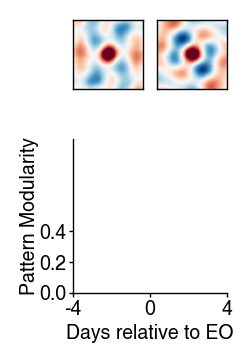

In [11]:

fig  = plt.figure(figsize=cm2inch(3,4.5)) 
plt.subplots_adjust(left=0.3, bottom=0.17, right=0.95, top=0.95, hspace=0.4)

gs = fig.add_gridspec(2,2, height_ratios=[1,2])
ax1 = fig.add_subplot(gs[0, 0])
ax3 = fig.add_subplot(gs[0, 1], sharex=ax1, sharey=ax1)
ax2 = fig.add_subplot(gs[1,:])
#ax3 = fig.add_subplot(gs[1, :])



#average autocorr
ax1.imshow(CC_naiveI, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
          extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax1.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax1.set_xticks([-0.6,0,0.6])
# ax1.set_yticks([-0.6,0,0.6]) 
ax1.spines[['right', 'top']].set_visible(True)


ax3.imshow(CC_expI, cmap='RdBu_r', vmax=0.6, vmin=-0.6,
         extent=[-1.89,1.89,-1.59,1.59,], aspect=1)
ax3.axis([-1*mm_dist,mm_dist,-1*mm_dist,mm_dist])
# ax3.set_xticks([-0.6,0,0.6])
ax3.set_yticks([]) 
ax3.set_xticks([]) 
ax3.spines[['right', 'top']].set_visible(True)


# ##lineplot
# key='MeanModularity'

# label='binoc'
# color='k'
# results=all_results_evoked["{}_{}".format(key,label)]
# ferret_days=all_results["all_EO_days"]

# ax2=plot_groupaverage(ax2,results,all_ferrets,
#                         ferret_days,color, 
#                      age_bins = [-3.5,-0.5, 0.5, 3,  ],
#                      dates_plot=[-4,-2,0,np.nan,4,], upper_bound=9,
#                      plot_dp=True)


ax2.set_ylabel("Pattern Modularity", labelpad=0)
ax2.set_xlabel("Days relative to EO", labelpad=2)
# ax2.xaxis.set_label_coords(0.48,-0.12, )
# ax2.yaxis.set_label_coords(-0.23, 0.5, )
ax2.tick_params(length=1.5, width=0.5)

ax2.set_xticks([-4,0,4])
ax2.set_yticks([0, 0.2, 0.4])
fig.align_ylabels((ax1,ax2))
plt.show()
fig.savefig("Modularity_combined_singlepattern.pdf", dpi=200)
# fig.savefig("EPI_ttc_contra.png", dpi=2000)